# Models Comparison

A supplimentary analysis for [Face Keypoints Detection with Keras](face_keypoints.ipynb) notebook that validates compares trained models performance.

In [26]:
%matplotlib inline

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
import os
import re
import glob
import json
from os.path import join, basename
from collections import OrderedDict

In [5]:
import numpy as np
import pandas as pd
from matplotlib import rcParams, rcParamsDefault
import matplotlib.pyplot as plt

In [6]:
from basedir import LFPW_VALID
from models import load_custom_model
from generators import AnnotatedImagesGenerator
from utils import best_checkpoint_path, show_images

/home/ck/anaconda3/envs/deep/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [7]:
PATH = join(os.environ['TF_MODELS_DIR'], 'face_landmarks')

In [8]:
def get_first_file(folder, ext):
    for name in glob.glob(f'{folder}/**'):
        if name.endswith(ext):
            return name
    return None

In [9]:
def parse_loss(string):
    try:
        [(epoch, loss)] = re.findall('([\d]+)_([\d]+\.[\d]+).hdf5$', string)
        return int(epoch), float(loss)
    except ValueError:
        return None

In [10]:
def best_checkpoint_path(folder):
    best_loss = np.inf
    best_epoch = 0
    best_file = None
    for filename in os.listdir(folder):
        if not filename.endswith('.hdf5'):
            continue
        value = parse_loss(filename)
        if value is None:
            continue
        epoch, loss = value
        if loss < best_loss:
            best_loss = loss
            best_epoch = epoch
            best_file = join(folder, filename)
    return best_epoch, best_loss, best_file

In [11]:
def read_models_specs(path):
    specs = {}
    
    for folder in glob.glob(f'{path}/**'):
        identifier = basename(folder)
        json_path = get_first_file(folder, '.json')
        csv_path = get_first_file(folder, '.csv')
        epoch, loss, weights = best_checkpoint_path(folder)
        
        if not (json_path and csv_path and weights):
            print(f'Error: model "{identifier}" doesn\'t have required files')
            continue
        
        with open(json_path) as file:
            params = json.load(file)
            
        spec = params.copy()
        spec['identifier'] = identifier
        spec['valid_loss'] = loss
        spec['weights'] = weights
        spec['history'] = pd.read_csv(csv_path)
        spec['best_epoch'] = epoch
        spec['stop_epoch'] = len(spec['history'])
        specs[identifier] = spec
        
    return specs

In [12]:
def create_comparison_table(specs):

    def list_as_string(x):
        if not x:
            return np.NAN
        return ', '.join([str(value) for value in x])
    
    records = [OrderedDict([
        ('Name', identifier),
        ('# of dense', spec['n_dense']),
        ('Batch Norm?', spec['bn']),
        ('Dropout?', bool(spec['dropouts'])),
        ('Dropout Probs', spec['dropouts']),
        ('MaxNorm', spec['maxnorm']),
        ('L2', spec['l2_reg']),
        ('Val. Loss', spec['valid_loss']),
        ('Total Epochs', spec['stop_epoch']),
        ('Best Epoch', spec['best_epoch'])
    ]) for identifier, spec in specs.items()]
    stats = pd.DataFrame(records)
    stats['Dropout Probs'] = stats['Dropout Probs'].apply(list_as_string)
    stats.sort_values(by=['Val. Loss', 'Name'], inplace=True)
    return stats

In [13]:
specs = read_models_specs(PATH)

In [14]:
create_comparison_table(specs)

,Name,# of dense,Batch Norm?,Dropout?,Dropout Probs,MaxNorm,L2,Val. Loss,Total Epochs,Best Epoch
1,inception_resnet_v2_no_reg,5,True,False,NaN,NaN,NaN,18.7795,585,85
2,inception_resnet_v2,5,True,True,"0.5, 0.5, 0.25, 0.25, 0.25",NaN,NaN,20.8661,445,195
0,inception_resnet_v2_all_reg,5,True,False,NaN,3.0,0.001,23.2583,726,226


In [30]:
style = {
    'figure.figsize': (10, 8),
    'figure.frameon': False,
    'font.size': 14}

rcParams.update(rcParamsDefault)
rcParams.update(style)

In [31]:
def create_training_curves(specs):
    min_epoch = min([spec['stop_epoch'] for spec in specs.values()])
    fig = plt.figure()
    fig.tight_layout()
    ax = fig.add_subplot(111)
    for identifier, spec in specs.items():
        loss = spec['history'].val_loss[:min_epoch]
        ax.plot(loss, label=identifier)
    ax.legend(loc='best')

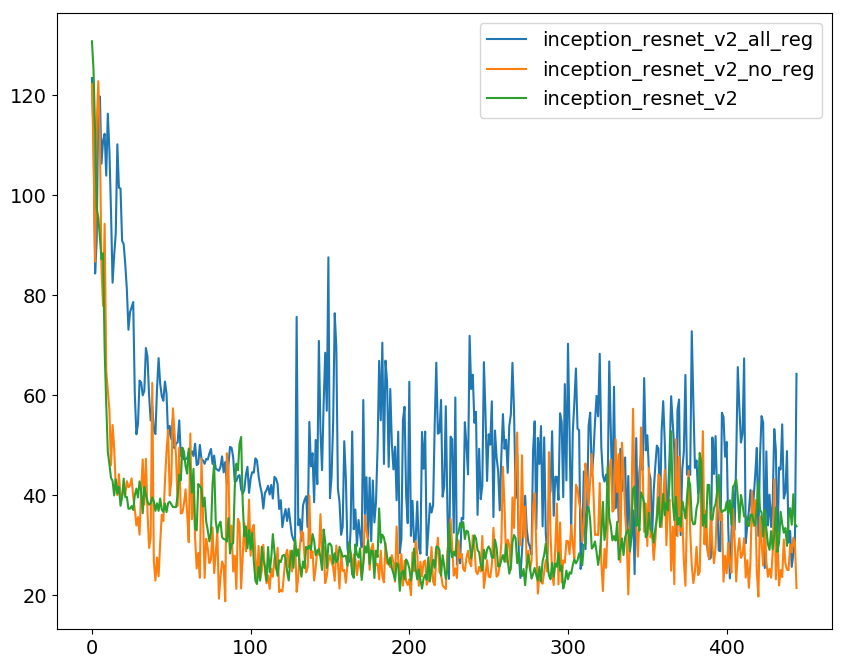

In [32]:
create_training_curves(specs)

In [33]:
model = load_custom_model(specs['inception_resnet_v2_no_reg']['weights'])

In [58]:
input_shape = model.input.shape.as_list()[1:]
target_size = tuple(input_shape[:2])
shift = target_size[0] / 2

In [59]:
gen = AnnotatedImagesGenerator(
    root=LFPW_VALID, 
    batch_size=16, target_size=target_size,
    normalize=False, augment=False)

In [63]:
x_test, y_test = next(gen)
y_pred = model.predict(x_test)
show_images(x_test, y_pred, y_test)

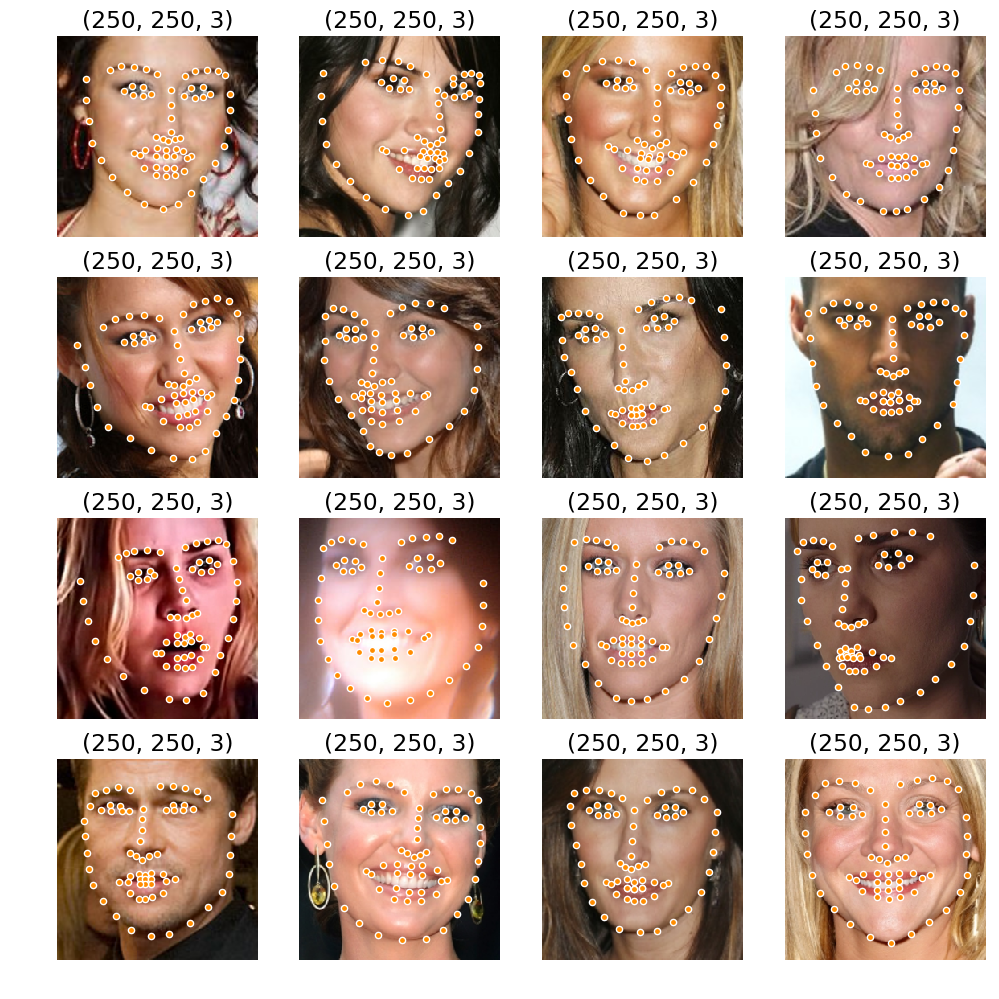

In [72]:
show_images(x_test, y_test)